# 0. Loading libraries

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
print('ready')


ready


In [15]:
# Function to plot MSE for each combination of hyperparameters
def plot_mse_results(results):
    learning_rates = list(set([r[0] for r in results]))
    weight_decays = list(set([r[1] for r in results]))

    mse_matrix = np.zeros((len(learning_rates), len(weight_decays)))

    for lr_idx, lr in enumerate(learning_rates):
        for wd_idx, wd in enumerate(weight_decays):
            for r in results:
                if r[0] == lr and r[1] == wd:
                    mse_matrix[lr_idx, wd_idx] = r[2]

    plt.figure(figsize=(10, 8))
    sns.heatmap(mse_matrix, annot=True, fmt=".4f", xticklabels=weight_decays, yticklabels=learning_rates)
    plt.xlabel('Weight Decay')
    plt.ylabel('Learning Rate')
    plt.title('Mean Squared Error for different Hyperparameter combinations')
    plt.show()

# Function to plot predicted vs actual values
def plot_predictions(model, X, y):
    model.eval()
    with torch.no_grad():
        predictions = model(X).numpy()

    plt.figure(figsize=(10, 6))
    plt.scatter(y.numpy(), predictions, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.title('Actual vs Predicted values')
    plt.show()

# Plot MSE results
#plot_mse_results(results)
#plot_predictions(best_model, X, y)

# Train the best model on the full dataset and plot predictions
best_lr, best_wd, _ = best_params
best_model = RegressionModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_lr, weight_decay=best_wd)

# Full dataset DataLoader with weighted sampling
full_data_loader = DataLoader(dataset, batch_size=32, sampler=sampler)

# Train the best model
best_model.train()
for epoch in range(20):
    for inputs, targets in full_data_loader:
        optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# Plot predictions for the best model
#plot_predictions(best_model, X, y)


# 1. Create a toy data

In [16]:
# Generate toy data
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Create a TensorDataset
dataset = TensorDataset(X, y)
print('ready toy data')

ready toy data


# 2. Define regressor model

In [17]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel,self).__init__()
        self.linear = nn.Linear(input_dim,1)
    def forward(self,x):
        return self.linear(x)

input_dim = X.shape[1]
model = RegressionModel(input_dim)

# 3. Correction for imbalance

In [18]:
# Compute sample weights based on the target distribution
target_mean = y.mean().item()
sample_weights = 1.0 / (torch.abs(y - target_mean) + 1.0)

# Create a weighted random sampler
sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights.squeeze(), num_samples=len(sample_weights), replacement=True)

# Create a DataLoader with the sampler
data_loader = DataLoader(dataset, batch_size=32, sampler=sampler)
print('ready correation')

ready correation


# 4. Parameter search and cross validation

In [19]:
# Parameter search space
learning_rates = [1e-3, 1e-2, 1e-1]
weight_decays = [0, 1e-4, 1e-3]

# Cross-validation setup
kf = KFold(n_splits=5)
results = []

# Perform random search
for lr, wd in product(learning_rates, weight_decays):
    fold_mses = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=32, sampler=torch.utils.data.WeightedRandomSampler(weights=sample_weights[train_index].squeeze(), num_samples=len(train_index), replacement=True))
        
        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=32)

        model = RegressionModel(input_dim)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

        # Train the model
        model.train()
        for epoch in range(20):
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        # Validate the model
        model.eval()
        all_preds = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                all_preds.extend(outputs.numpy())
        
        mse = mean_squared_error(y_val, all_preds)
        fold_mses.append(mse)

    avg_mse = np.mean(fold_mses)
    results.append((lr, wd, avg_mse))
    print(f"LR: {lr}, WD: {wd}, MSE: {avg_mse:.4f}")

# Find best parameters
best_params = min(results, key=lambda x: x[2])
print(f"Best Parameters - LR: {best_params[0]}, WD: {best_params[1]}, MSE: {best_params[2]:.4f}")


LR: 0.001, WD: 0, MSE: 33557.1016
LR: 0.001, WD: 0.0001, MSE: 33558.6484
LR: 0.001, WD: 0.001, MSE: 33570.5391
LR: 0.01, WD: 0, MSE: 30861.0840
LR: 0.01, WD: 0.0001, MSE: 30787.2559
LR: 0.01, WD: 0.001, MSE: 30759.1445
LR: 0.1, WD: 0, MSE: 11563.2295
LR: 0.1, WD: 0.0001, MSE: 11622.8174
LR: 0.1, WD: 0.001, MSE: 11316.8076
Best Parameters - LR: 0.1, WD: 0.001, MSE: 11316.8076


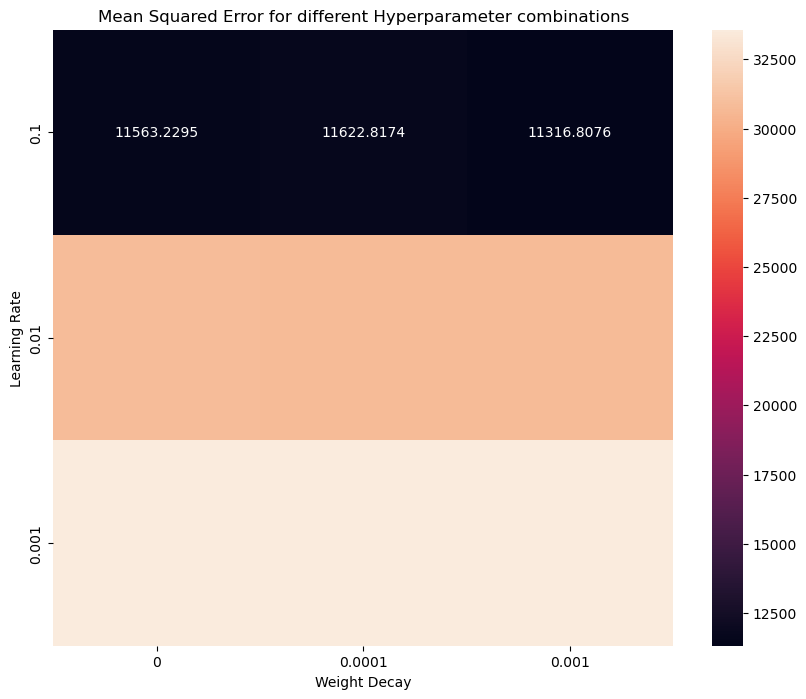

In [20]:
plot_mse_results(results)

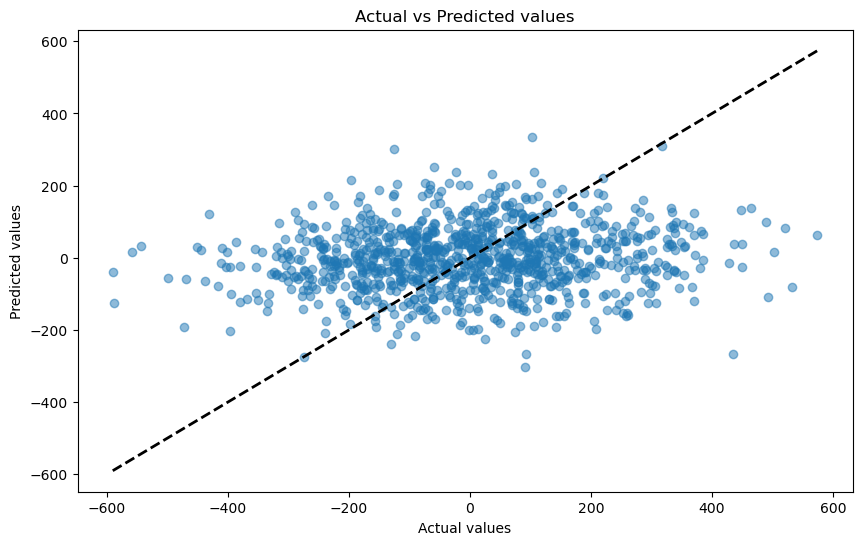

In [21]:
plot_predictions(best_model, X, y)